In [12]:
!git clone 'https://github.com/Lorenz92/SKADC1.git'
% cd SKADC1
!echo $PWD

Cloning into 'SKADC1'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 17), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os

import src.dataset as dataset
import src.config as config
from src.utils import *

# from src.config import * 

%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [7]:
for download_info in config.required_files:
    if not os.path.exists(os.path.join(config.TRAIN_DATA_FOLDER, download_info['file_name'])):
        download_data(download_info['file_name'], download_info['url'], config.DOWNLOAD_FOLDER)

Download completed!
Download completed!


In [ ]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH, subset=config.DATA_SUBSET)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

In [8]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
# data_560Mhz_1000h_fits.info()
data_560Mhz_1000h_fits.filename()

# print(data_560Mhz_1000h_fits[0].data)
# print(data_560Mhz_1000h_fits[0].data.shape)

data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]


In [7]:
data_560Mhz_1000h_fits[0].header

SIMPLE  =                    T  /                                               
BITPIX  =                  -32  /                                               
NAXIS   =                    4  /                                               
NAXIS1  =                32768  /                                               
NAXIS2  =                32768  /                                               
NAXIS3  =                    1  /                                               
NAXIS4  =                    1  /                                               
EXTEND  =                    T  /                                               
BSCALE  =    1.00000000000E+00  /                                               
BZERO   =    0.00000000000E+00  /                                               
BLANK   =                   -1  /                                               
BUNIT   = 'JY/BEAM '  /                                                         
DATE-OBS= '2000-01-01T12:00:

In [8]:
data_9200Mhz_1000h_fits = fits.open('./data/training/9200Mhz_1000h.fits')
# data_9200Mhz_1000h_fits.info()
data_9200Mhz_1000h_fits.filename()

# print(data_9200Mhz_1000h_fits[0].data)
# print(data_9200Mhz_1000h_fits[0].data.shape)

data_9200Mhz_1000h = data_9200Mhz_1000h_fits[0].data[0,0]


In [12]:
# Visualization test
from astropy.io import fits
from astropy.utils.data import download_file

# image_file = download_file('https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download', cache=True )

# image_data = fits.getdata(image_file)
# image_data = image_data.reshape(image_data.shape[2:])

# compute per value to clip the image
perc = 99.9
percentileThresh = np.percentile(data_9200Mhz_1000h, perc)
print (f'{perc} percentile {percentileThresh}')

# # crop the image to speed up computation and clip using per value
# image_crop= image_data[5000:10000, 5000:10000]
# image_crop.clip(max=percentileThresh)

# plt.figure(figsize=(100, 100))
# # plt.imshow(normalized_data, cmap='viridis', vmax=255, vmin=0)
# for idx in range(25):
#     plt.subplot(5, 5, idx+1)
#     plt.axis('off')
#     base = 200 * idx
#     end = base + 200
#     normalized_data = image_crop[base:end, base:end] * (1.0 / percentileThresh)
#     plt.imshow(normalized_data, cmap='viridis', vmax=1, vmin=0)

99.9 percentile 1.217370311223931e-07


### Preprocessing

In [45]:
data_560Mhz_1000h_train = data_560Mhz_1000h[17280:17300, 18800:18820]


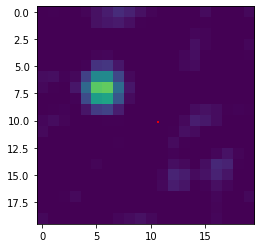

In [50]:
from matplotlib.patches import Rectangle


plt.imshow(data_560Mhz_1000h_train * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)
# plt.plot(10.611, 10.068, 'ro', markersize=1) # 18810.611, 17290.068
plt.gca().add_patch(Rectangle((10.573179, 10.032021), 18810.640098-18810.573179, 17290.100855 - 17290.032021,linewidth=1,edgecolor='r',facecolor='none')) #18810.573179	17290.032021	18810.640098	17290.100855


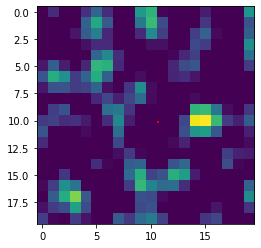

In [14]:
from matplotlib.patches import Rectangle

data_9200Mhz_1000h_train = data_9200Mhz_1000h[17280:17300, 18800:18820]

plt.imshow(data_9200Mhz_1000h_train * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)
# plt.plot(10.611, 10.068, 'ro', markersize=1) # 18810.611, 17290.068
plt.gca().add_patch(Rectangle((10.573179, 10.032021), 18810.640098-18810.573179, 17290.100855 - 17290.032021,linewidth=1,edgecolor='r',facecolor='none')) #18810.573179	17290.032021	18810.640098	17290.100855



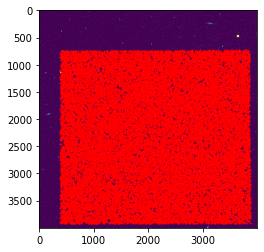

In [28]:

from matplotlib.patches import Rectangle

# data_9200Mhz_1000h_train = data_9200Mhz_1000h[17280:17300, 18800:18820]
data_9200Mhz_1000h_train=data_9200Mhz_1000h[16000:20000, 16000:20000]
plt.imshow(data_9200Mhz_1000h_train * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)
plt.plot(ska_dataset.raw_train_df['x'].apply(lambda x: x - 16000), ska_dataset.raw_train_df['y'].apply(lambda x: x - 16000), 'ro', markersize=1)
# plt.plot(ska_dataset.raw_train_df['x'], ska_dataset.raw_train_df['y'], 'ro', markersize=1)


In [24]:
coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header)
print(coords['x1'][0])

18810.573179053437


In [25]:
pd.DataFrame.from_dict(coords)

,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,18810.573179,17290.032021,18810.640098,17290.100855,0.038891,0.028134,0.830515,0.066919,0.068834
1,18248.990411,19229.924516,18249.167163,19230.045839,0.090195,0.057923,-0.263702,0.176752,0.121323
2,17089.993033,18059.755275,17091.318972,18060.334761,0.664461,0.286306,0.074281,1.325938,0.579486
3,17075.943351,19103.797290,17076.110959,19104.121460,0.164667,0.078610,-1.368687,0.167608,0.324171
4,16714.132980,17291.521466,16714.257327,17291.696762,0.093504,0.052958,-1.134394,0.124347,0.175295
...,...,...,...,...,...,...,...,...,...
27483,19175.702751,18100.831203,19177.574063,18102.417359,1.215558,0.163840,-0.700034,1.871312,1.586155
27484,18851.979340,17239.912004,18852.221077,17240.172839,0.152255,0.091850,-0.867132,0.241737,0.260836
27485,17077.553096,19457.481254,17077.748817,19457.770952,0.153083,0.084402,1.172547,0.195722,0.289698
27486,19074.180372,16979.938079,19075.582530,16980.838143,0.831611,0.049648,-0.569030,1.402159,0.900064


In [26]:
df_train = ska_dataset._extend_dataframe(ska_dataset.raw_train_df, coords)
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,22923268,-0.469784,-29.846916,-0.469784,-29.846916,4.579590e-08,-0.0,0.047,0.034,47.585,...,17290.068,18810.573179,17290.032021,18810.640098,17290.100855,0.038891,0.028134,0.830515,0.066919,0.068834
1,21867980,-0.359950,-29.521645,-0.359950,-29.521645,5.745240e-08,-0.0,0.109,0.070,-15.109,...,19229.991,18248.990411,19229.924516,18249.167163,19230.045839,0.090195,0.057923,-0.263702,0.176752,0.121323
2,25939522,-0.136767,-29.718441,-0.136767,-29.718441,9.155150e-07,-0.0,0.803,0.346,4.256,...,18060.048,17089.993033,18059.755275,17091.318972,18060.334761,0.664461,0.286306,0.074281,1.325938,0.579486
3,16617483,-0.133707,-29.543222,-0.133707,-29.543222,3.988710e-07,-0.0,0.199,0.095,-78.420,...,19103.965,17075.943351,19103.797290,17076.110959,19104.121460,0.164667,0.078610,-1.368687,0.167608,0.324171
4,26912919,-0.064092,-29.847477,-0.064092,-29.847477,7.125110e-07,-0.0,0.113,0.064,-64.996,...,17291.611,16714.132980,17291.521466,16714.257327,17291.696762,0.093504,0.052958,-1.134394,0.124347,0.175295


In [55]:
data_560Mhz_1000h_fits.filename()

33

In [72]:
patches={}
patches = split_in_patch(data_560Mhz_1000h_train, df_train, data_560Mhz_1000h_fits.filename(), 200)
print(len(patches))
# plt.imshow(patches[0] * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)
# plt.imshow(patches[10] , cmap='viridis')

4


In [ ]:
# First net version
from tensorflow import keras

FROZEN_LAYERS_IDX = [1, 2, 4, 5]
ANCHOR_NUM = 9
PROB_PRED_OUT = 2 * ANCHOR_NUM
COORD_PRED_OUT = 4 * ANCHOR_NUM 

# Load pretrained VGG16 and remove last MaxPool layer
VGG16 = keras.applications.VGG16(include_top=False, input_shape=(600, 600, 3), weights="imagenet")
shared_conv = keras.Model(VGG16.input, VGG16.layers[-2].output, name="Shared Convolutional Net")

# Freeze first 4 convolutional layers
for idx in FROZEN_LAYERS_IDX:
  shared_conv.layers[idx].trainable = False

# Create Region Proposal Net
x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='RPN_Conv1')(shared_conv.output)
cls_pred = keras.layers.Conv2D(filters=PROB_PRED_OUT, kernel_size=(1, 1), padding='same', name='RPN_Cls_Conv')(x)
reg_pred = keras.layers.Conv2D(filters=COORD_PRED_OUT, kernel_size=(1, 1), padding='same', name='RPN_Reg_Conv')(x)

region_prop_net = keras.Model(shared_conv.input, [cls_pred, reg_pred], name='Region Proposal')

print(region_prop_net.summary())


ModuleNotFoundError: No module named 'tensorflow'